In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from importlib import reload

import tensorflow as tf

In [2]:
import domain
import network
import PINN

## Sampling points in the domain

<IPython.core.display.Javascript object>


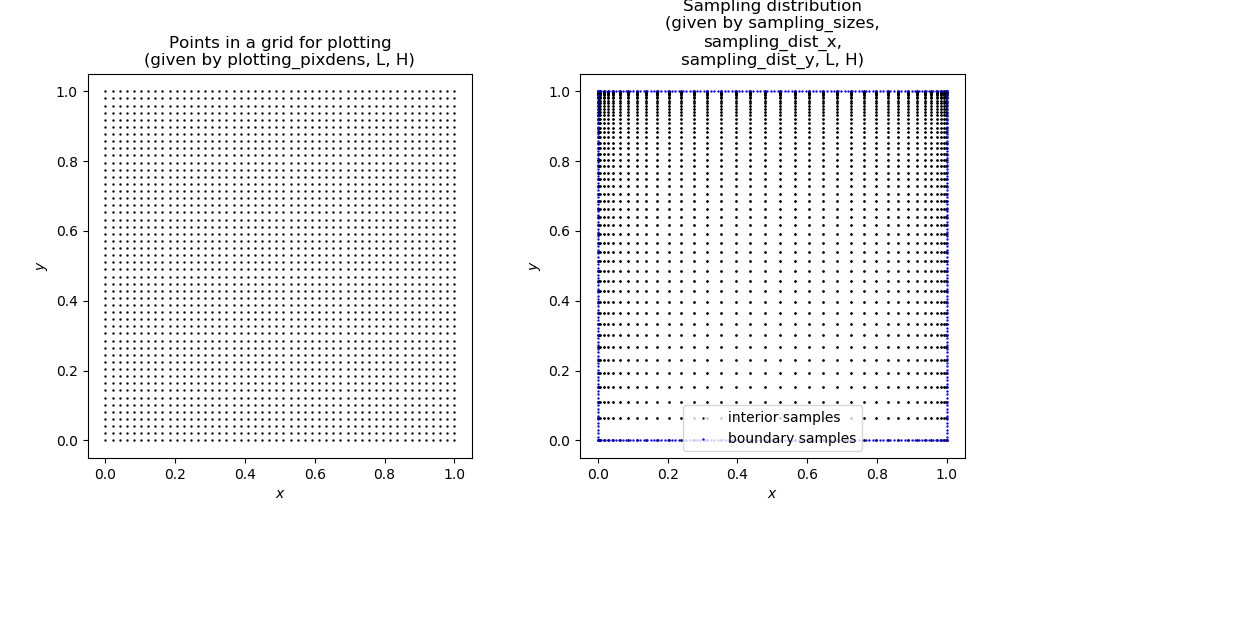

In [3]:
reload(domain)

# Domain dimensions
L     = 1
H     = 1

D    = domain.rectangular_domain(L=L, H=H, plotting_pixdens = 50, sampling_sizes = (75,50),
                                 sampling_dist_x = lambda x: np.sin(np.pi*x)**2,
                                 sampling_dist_y = lambda y: np.sin(np.pi*y/2)**0.8)

fig, axs = plt.subplots(1,2, figsize = (10*L,5*H))

axs[0].set_title("Points in a grid for plotting\n(given by plotting_pixdens, L, H)")
axs[0].scatter(D.plotting_grid[:,0], D.plotting_grid[:,1], s = 0.5, color = 'k')

D.update_samples()

axs[1].set_title("Sampling distribution\n(given by sampling_sizes,\nsampling_dist_x,\nsampling_dist_y, L, H)")
axs[1].scatter(D.interior_samples[:,0],D.interior_samples[:,1], s = 0.5, c = 'k', label = 'interior samples')
axs[1].scatter(D.boundary_samples[:,0],D.boundary_samples[:,1], s = 0.5, c = 'b', label = 'boundary samples')
axs[1].legend()

for ax in axs:
    ax.set_xlabel("$x$")
    ax.set_ylabel("$y$")
    ax.set_aspect('equal','box')
    
fig.tight_layout()
fig.canvas.draw();

## The network architecture

<IPython.core.display.Javascript object>


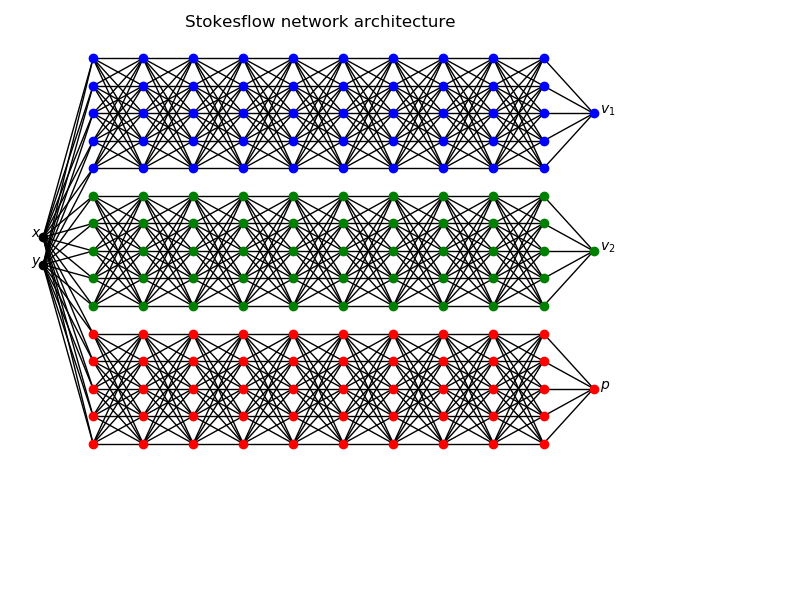

Model: "stokesflow_branched"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 2)]          0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 5)            15          input_1[0][0]                    
__________________________________________________________________________________________________
dense_11 (Dense)                (None, 5)            15          input_1[0][0]                    
__________________________________________________________________________________________________
dense_22 (Dense)                (None, 5)            15          input_1[0][0]                    
________________________________________________________________________________

In [4]:
reload(network)
reload(PINN)

# Note: here we use the second class form both the network and the PINN scripts, the first one is for the warm-up exericse

# Model = network.construct_model_stokesflow(hidden_layer_widths = np.array(7*[10]),
#                                            activation_function = tf.nn.tanh)

model_assembler = network.model_stokesflow_branched(branch_widths = 10*[5])
model_assembler.plot_model()
Model = model_assembler.assemble_full_model()
Model.summary()

# Optimizer = tf.keras.optimizers.Adam(learning_rate=0.001,
#                                      beta_1=0.99,
#                                      epsilon=1e-7)
Optimizer = tf.keras.optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=1e-08)

# Defining functions that descrive the boundary conditions (in order left, right, top bottom, standard is all 0)
BCs_v1    = 4*[lambda x: 0*x]
BCs_v1[2] = lambda x: 0*x +1

# Standard we have f = 0
# The loss weights are in the order incompressibility, PDE, boundaries

loss_weights = np.array([1,1,10])
loss_weights = loss_weights/np.sum(loss_weights) # always normalize weights

NN = PINN.PINN_object_stokesflow(D, Model, Optimizer, BCs_v1 = BCs_v1, loss_weights = loss_weights)

## Training

<IPython.core.display.Javascript object>


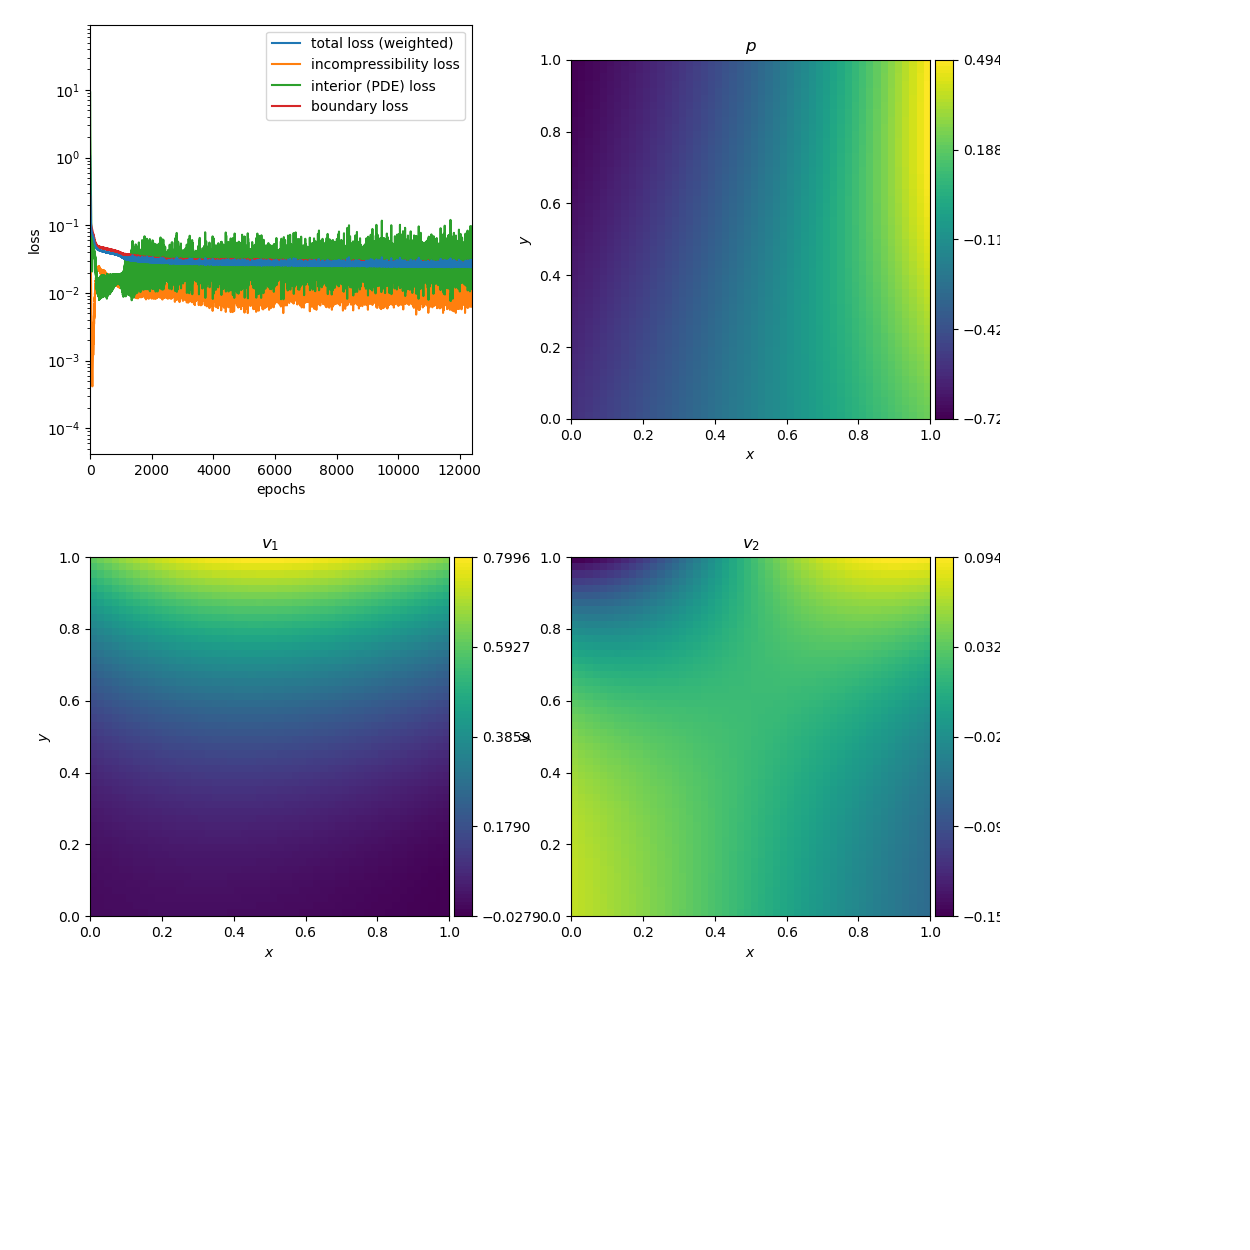

KeyboardInterrupt: 

In [5]:
NN.fit(n_epochs = 25000,
       plot_update_interval = 50);

In [ ]:
plt.savefig("Stokesflow.png")